In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [2]:
#Load in training data
df = pd.read_csv('./data/movementSensorData.csv')

### Exploring the data

In [3]:
df.head()

,id,activity,time_s,lw_x,lw_y,lw_z
0,63804,2,638.05,-0.188,-0.941,-0.316
1,63805,2,638.06,-0.121,-0.879,-0.320
2,63806,2,638.07,-0.070,-0.852,-0.305
3,63807,2,638.08,-0.023,-0.879,-0.277
4,63808,2,638.09,0.008,-0.941,-0.242


In [4]:
df.shape

(507827, 6)

In [5]:
df.describe()

,id,activity,time_s,lw_x,lw_y,lw_z
count,507827.000000,507827.000000,507827.000000,507827.000000,507827.000000,507827.000000
mean,167785.101830,4.191809,1677.861018,-0.211302,-0.021941,-0.477602
std,63888.316941,8.785676,638.883169,0.524070,0.727952,0.443465
min,63804.000000,1.000000,638.050000,-5.289000,-5.305000,-6.875000
25%,89195.000000,2.000000,891.960000,-0.734000,-0.219000,-0.828000
50%,188844.000000,4.000000,1888.450000,-0.098000,0.184000,-0.570000
75%,220583.000000,4.000000,2205.840000,0.176000,0.426000,-0.148000
max,252322.000000,77.000000,2523.230000,5.516000,4.418000,4.551000


In [6]:
df.isnull().sum()

id          0
activity    0
time_s      0
lw_x        0
lw_y        0
lw_z        0
dtype: int64

In [7]:
df['activity'].unique()

array([ 2, 77,  1,  3,  4], dtype=int64)

So we have activites 1, 2, 3, 4, and 77. From the source (https://physionet.org/content/accelerometry-walk-climb-drive/1.0.0/#files) we know that these are:
- 1 Walking
- 2 Descending Stairs
- 3 Ascending Stairs
- 4 Driving
- 77 Clapping


### Preprocessing

In [8]:
scaler=StandardScaler()
scaler.fit(df)
scaler_train = scaler.transform(df)

In [9]:
X = df.iloc[:, 2:6] #time and data minus activity
y = df.iloc[:, 1] #just activity
print(X)
print(y)

        time_s   lw_x   lw_y   lw_z
0       638.05 -0.188 -0.941 -0.316
1       638.06 -0.121 -0.879 -0.320
2       638.07 -0.070 -0.852 -0.305
3       638.08 -0.023 -0.879 -0.277
4       638.09  0.008 -0.941 -0.242
...        ...    ...    ...    ...
507822  963.87 -0.012  0.984 -0.363
507823  963.88  0.016  0.938 -0.379
507824  963.89  0.039  0.910 -0.391
507825  963.90  0.066  0.898 -0.395
507826  963.91  0.105  0.895 -0.398

[507827 rows x 4 columns]
0         2
1         2
2         2
3         2
4         2
         ..
507822    1
507823    1
507824    1
507825    1
507826    1
Name: activity, Length: 507827, dtype: int64


In [10]:
#ts_cv = TimeSeriesSplit(
#    n_splits=5,
#    gap=48,
#    max_train_size=10000,
#    test_size=1000,
#)
#
#all_splits = list(ts_cv.split(X, y))
#train_0, test_0 = all_splits[0]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=101)

### Training & Testing

In [12]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(max_depth=2, random_state=1452)
random_forest.fit(X_train, y_train) 

RandomForestClassifier(max_depth=2, random_state=1452)

In [13]:
test_pred = random_forest.predict(X_validation)
metrics.f1_score(y_validation, test_pred, average='weighted')

0.8902996258637927

In [14]:
import time

start_time = time.time()
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.003 seconds


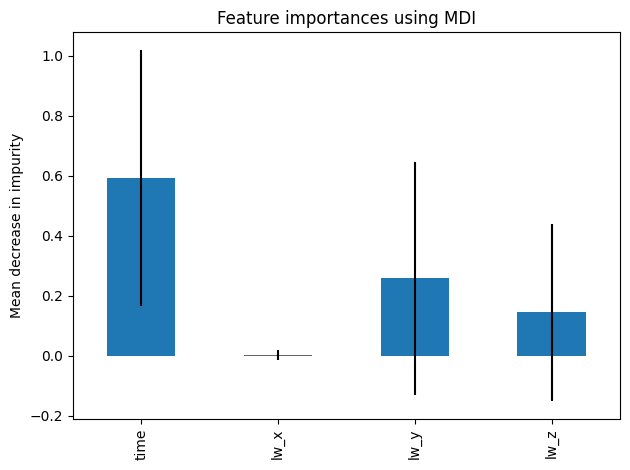

In [15]:
#import time
#
#start_time = time.time()
#importances = random_forest.feature_importances_
#std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
#elapsed_time = time.time() - start_time
#
#print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
#
#forest_importances = pd.Series(importances, index=['time', 'lw_x', 'lw_y', 'lw_z'])
#
#fig, ax = plt.subplots()
#forest_importances.plot.bar(yerr=std, ax=ax)
#ax.set_title("Feature importances using MDI")
#ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()
#plt.show()

Looks like X movement isn't very important for classifying our activities...

In [16]:
X = X.drop(columns='lw_x')
X

,time_s,lw_y,lw_z
0,638.05,-0.941,-0.316
1,638.06,-0.879,-0.320
2,638.07,-0.852,-0.305
3,638.08,-0.879,-0.277
4,638.09,-0.941,-0.242
...,...,...,...
507822,963.87,0.984,-0.363
507823,963.88,0.938,-0.379
507824,963.89,0.910,-0.391
507825,963.90,0.898,-0.395
